# DS Project no. 2: Kickstarter data set  
by Sandra Schwegmann & Marvin Lorenzen

## Project Goal

Buildung the scene:  
We are a non-profit organization that helps people to find out **which probability they have to get funded** by kickstarters with their projects and what they **can do to improve their chances**.

## Data Describtion

        backers_count:              number of supporters 
        blurb                       teaser sentence
        category                    dictonary
        converted_pledged_amount:   ?
        country                     209222 non-null object
        created_at                  209222 non-null int64
        creator                     209222 non-null object
        currency                    209222 non-null object
        currency_symbol             209222 non-null object
        currency_trailing_code      209222 non-null bool
        current_currency            209222 non-null object
        deadline                    209222 non-null int64
        disable_communication       209222 non-null bool
        friends                     300 non-null object
        fx_rate                     209222 non-null float64
        goal                        target sum
        id                          209222 non-null int64
        is_backing                  300 non-null object
        is_starrable                ?
        is_starred                  300 non-null object
        launched_at                 209222 non-null int64
        location                    208996 non-null object
        name                        209222 non-null object
        permissions                 300 non-null object
        photo                       209222 non-null object
        pledged                     promised money
        profile                     209222 non-null object
        slug                        ?
        source_url                  209222 non-null object
        spotlight                   use the spotlight-function, which is an integrated homepage
        staff_pick                  tool to connect creators and backers
        state                       status of the project
        state_changed_at            209222 non-null int64
        static_usd_rate             factor for conversion in USD
        urls                        209222 non-null object
        usd_pledged                 promised money in usd
        usd_type                    208742 non-null object

# Data Handling

## Import packages

In [1]:
import pandas as pd
import glob
import numpy as np
import operator
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import median

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 
from sklearn.base import clone

%matplotlib inline
plt.style.use('seaborn')
sns.set(style="darkgrid")

# Set random seed 
RSEED = 42

## Read in Data

In [2]:
# Read in data: loop over all files
path = '/Users/sandra/Documents/materials/Project-2_Kickstarter/data'
filenames = glob.glob(path + "/*.csv")
comlete_csv =[]

for i in filenames:
    comlete_csv.append(pd.read_csv(i,encoding='utf-8'))

df = pd.concat(comlete_csv, ignore_index = True)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209222 entries, 0 to 209221
Data columns (total 37 columns):
backers_count               209222 non-null int64
blurb                       209214 non-null object
category                    209222 non-null object
converted_pledged_amount    209222 non-null int64
country                     209222 non-null object
created_at                  209222 non-null int64
creator                     209222 non-null object
currency                    209222 non-null object
currency_symbol             209222 non-null object
currency_trailing_code      209222 non-null bool
current_currency            209222 non-null object
deadline                    209222 non-null int64
disable_communication       209222 non-null bool
friends                     300 non-null object
fx_rate                     209222 non-null float64
goal                        209222 non-null float64
id                          209222 non-null int64
is_backing                  300 

In [4]:
df.head(2)

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,...,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,315,Babalus Shoes,"{""id"":266,""name"":""Footwear"",""slug"":""fashion/fo...",28645,US,1541459205,"{""id"":2094277840,""name"":""Lucy Conroy"",""slug"":""...",USD,$,True,...,babalus-childrens-shoes,https://www.kickstarter.com/discover/categorie...,False,False,live,1548223375,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",28645.0,international
1,47,A colorful Dia de los Muertos themed oracle de...,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",1950,US,1501684093,"{""id"":723886115,""name"":""Lisa Vollrath"",""slug"":...",USD,$,True,...,the-ofrenda-oracle-deck,https://www.kickstarter.com/discover/categorie...,True,False,successful,1504976459,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",1950.0,domestic


* data like dictonaries: 
    * category
    * creator
    * location
    * photo
    * profile
* photo will be dropped, other stay at the moment
* other object variables:
    * friends    - nothing in friends - dropped
    * is_backing - False
    * is_starred - False
    * permission - nothing in friends - dropped
* also drop source_url and urls

## Data cleaning

In [5]:
#drop first columns
df.drop(['photo','friends','permissions','currency_symbol',\
             'source_url','urls'],axis=1, inplace=True)

### Clean null, false etc

In [6]:
# clean data from empty spaces, line breaks, etc.
dict_list1 = ['location','profile','creator']
for names in dict_list1:
    df[names] = df[names].str.replace(':null,',':None,')
    df[names] = df[names].str.replace(':false,',':False,')
    df[names] = df[names].str.replace(':true',':True')
    df[names] = df[names].str.replace('\n', '')
    df[names] = df[names].str.replace('\t', '')
    

* test which projects are still active
* test whether currency is always USD
* create a new variable project length and length per 100USD (or so)

In [7]:
print(df.shape)
len(df.state[df.state == 'live'])

(209222, 31)


7311

### Proof goal currency

In [8]:
test = df[['goal','usd_pledged','pledged']][(df.state=='successful')]
test[(df.current_currency!=df.currency)]

/Users/sandra/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,goal,usd_pledged,pledged
8,375.0,529.786729,375.00
9,380.0,2516.160602,1954.00
16,4200.0,4701.023782,4230.00
17,15000.0,15328.270782,20169.00
22,1000.0,702.613237,1015.00
25,2000.0,2861.258251,2199.00
29,350.0,435.427090,376.00
32,11000.0,14580.639568,11784.00
34,2000.0,3196.518202,2055.00
35,1800.0,1325.061424,1838.32


### Unravel dictonary variables

In [9]:
# get fom creator ids -> remaining parts are ignored
# First separate creator elements
new2 = df["creator"].str.replace(", ", "_").str.split(",", n = 8, expand = True)
# now pick first column in new2 and split at :
test = new2[0].str.split(":")
# pick 2. column in test (where ids are written in)
test2 = list(map(operator.itemgetter(1), test))
# and make a new column in df with ids
df["creator_id"]=pd.Series(test2)
# convert ids to numeric values
df["creator_id"] = pd.to_numeric(df["creator_id"])

* We excluded everything after blurb as we could not manage to remove wrong entries -> has to be fixed...

In [10]:
# prepare profile data
# First separate creator elements
#new  = df["profile"].str.replace(", ", "_")
new  = df["profile"].str.replace(',"', ';;"')
new2 = new.str.split(";;", n = 16, expand = True)                                 
#new2 = new.str.replace(",000 ", "000").str.split(",", n = 16, expand = True)
# now drop column 4:
new3 = new2.drop(4, axis =1)
# change blurb to has or has no blurb
new3[5][new3[5]!='"blurb":"none"'] = '"blurb":"1"' #0 if new3[5]== "none" else 1
new3[5][new3[5]=='"blurb":"none"'] = '"blurb":"0"' #0 if new3[5]== "none" else 1

# change link_text to has or has not
#new3[10][new3[10]!='"link_text":"none"'] = '"link_text":"1"' #0 if new3[5]== "none" else 1
#new3[10][new3[10]=='"link_text":"none"'] = '"link_text":"0"' #0 if new3[5]== "none" else 1

new3[17]='"dummy":"dummy"}'
# pick columns of interest: 
#new3["profile"]= new3[[0,1,2,3,5,6,7,8,9,10,11,12,13,17]].apply(lambda x: ','.join(x), axis=1)
new3["profile"]= new3[[0,1,2,3,5,17]].apply(lambda x: ','.join(x), axis=1)
# write data in df
df["profile_test"] =new3["profile"]

In [11]:
# prepare location data
# dummy for NaN entries
location_dummy= '{"id":"","name":"","slug":"","short_name":"","displayable_name":"","localized_name":"",\
                "country":"","state":"","type":"","is_root":None,"urls":{}}'
#replace NaNs with dummy
df.location[df.location.isnull()] = location_dummy

/Users/sandra/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
# extraction of data dictonaries in 'category','location'
dict_list = ['category','location','profile_test']#['category','location','profile''creator']#, null false true

for names in dict_list:
    print(names)
    new_name     = names+'new'
    suffix       = names+'_'
    df[new_name] = df[names].apply(eval)
    test         = df[new_name].apply(pd.Series)
    test         = test.add_prefix(suffix)
    df           = pd.concat([df,test],axis=1)  
 

category
location
profile_test


### Remove projects that are live, canceled or suspended

In [13]:
# das ging doch irgendwie schöner mit eval...
#df = df[df.state==("successful" or "failed")]
df = df[df.state!='canceled']
df = df[df.state!='live']
df = df[df.state!='suspended']
df.shape

(192664, 60)

In [14]:
df.describe().round(2)

,backers_count,converted_pledged_amount,created_at,deadline,fx_rate,goal,id,launched_at,pledged,state_changed_at,static_usd_rate,usd_pledged,creator_id,category_id,category_position,category_parent_id,category_color,profile_test_id,profile_test_project_id,profile_test_state_changed_at
count,192664.00,192664.00,1.926640e+05,1.926640e+05,192664.00,1.926640e+05,1.926640e+05,1.926640e+05,192664.00,1.926640e+05,192664.00,192664.00,1.926640e+05,192664.00,192664.00,184388.00,192664.00,192664.00,192664.00,1.926640e+05
mean,152.56,13505.68,1.453017e+09,1.459925e+09,1.00,4.528810e+04,1.072715e+09,1.457126e+09,19698.25,1.459925e+09,1.01,13516.72,1.074629e+09,176.45,6.93,11.76,11908899.29,2190319.85,2190319.85,1.469864e+09
std,898.35,89104.04,6.253226e+07,6.213787e+07,0.21,1.112931e+06,6.195476e+08,6.219951e+07,335111.71,6.213790e+07,0.23,89183.97,6.205606e+08,134.12,4.55,5.53,6016045.15,1063113.83,1063113.83,4.317010e+07
min,0.00,0.00,1.240366e+09,1.241334e+09,0.01,1.000000e-02,8.624000e+03,1.240603e+09,0.00,1.241334e+09,0.01,0.00,3.000000e+00,1.00,1.00,1.00,51627.00,19.00,19.00,1.425915e+09
25%,4.00,150.00,1.411574e+09,1.418587e+09,1.00,1.500000e+03,5.347017e+08,1.415810e+09,151.00,1.418587e+09,1.00,150.00,5.359004e+08,37.00,3.00,9.00,6526716.00,1376812.00,1376812.00,1.425916e+09
50%,30.00,1770.00,1.455448e+09,1.462130e+09,1.00,5.000000e+03,1.074132e+09,1.459349e+09,1800.00,1.462130e+09,1.00,1772.00,1.074181e+09,252.00,6.00,12.00,14867664.00,2373856.00,2373856.00,1.458412e+09
75%,94.25,7087.00,1.507230e+09,1.513998e+09,1.00,1.500000e+04,1.608192e+09,1.511201e+09,7463.00,1.513998e+09,1.00,7096.62,1.613398e+09,301.00,10.00,16.00,16743775.00,3170955.00,3170955.00,1.510459e+09
max,105857.00,8596474.00,1.551738e+09,1.552536e+09,1.75,1.000000e+08,2.147476e+09,1.551849e+09,81030744.00,1.552536e+09,1.72,8596474.58,2.147483e+09,389.00,19.00,26.00,16776056.00,3682030.00,3682030.00,1.552537e+09


### Other checkings

In [15]:
# test if there are any duplicated project ids
#df.profile_test_id[df.profile_test_id.duplicated(keep=False)]==True

# these need to be tested: one succeed and one failure? why, keep it or remove it, differences...

In [16]:
pd.value_counts(df.currency)

USD    137788
GBP     21235
EUR     12399
CAD      8896
AUD      4383
MXN      2038
SEK      1281
HKD       953
NZD       848
DKK       839
SGD       624
CHF       597
NOK       453
JPY       330
Name: currency, dtype: int64

In [17]:
pd.value_counts(df.current_currency)

USD    192626
CAD        38
Name: current_currency, dtype: int64

In [18]:
df.state[df.profile_test_id.duplicated(False)==True].describe()


count          47370
unique             2
top       successful
freq           45372
Name: state, dtype: object

In [19]:
test = df.id-df.profile_test_id
test.describe()


count    1.926640e+05
mean     1.070524e+09
std      6.195534e+08
min     -3.414918e+06
25%      5.324394e+08
50%      1.071987e+09
75%      1.606117e+09
max      2.147428e+09
dtype: float64

In [20]:
len(df.id[df.id.duplicated(keep=False)==True])

47370

In [21]:
len(df.profile_test_id[df.profile_test_id.duplicated(keep=False)==True])

47370

In [22]:
print(df.id[1])
print(df.profile_test_id[1])

928751314
3094785


In [23]:
test = df.groupby("id")["profile_test_id"].transform('count')
len(test)

192664

In [24]:
abc = df.profile_test_id.duplicated(keep=False)
print(df.id[abc].index,df.profile_test_id[abc].index)
abce = df.id[abc].index-df.profile_test_id[abc].index
max(abce)

Int64Index([     8,      9,     13,     14,     16,     17,     19,     26,
                29,     35,
            ...
            209173, 209176, 209179, 209184, 209196, 209199, 209202, 209214,
            209215, 209217],
           dtype='int64', length=47370) Int64Index([     8,      9,     13,     14,     16,     17,     19,     26,
                29,     35,
            ...
            209173, 209176, 209179, 209184, 209196, 209199, 209202, 209214,
            209215, 209217],
           dtype='int64', length=47370)


0

* id and profile_test_id are not the same but where profile_test_id occurs twice, also id does

## General Overview

In [25]:
df.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'created_at', 'creator', 'currency',
       'currency_trailing_code', 'current_currency', 'deadline',
       'disable_communication', 'fx_rate', 'goal', 'id', 'is_backing',
       'is_starrable', 'is_starred', 'launched_at', 'location', 'name',
       'pledged', 'profile', 'slug', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'usd_pledged', 'usd_type',
       'creator_id', 'profile_test', 'categorynew', 'category_id',
       'category_name', 'category_slug', 'category_position',
       'category_parent_id', 'category_color', 'category_urls', 'locationnew',
       'location_id', 'location_name', 'location_slug', 'location_short_name',
       'location_displayable_name', 'location_localized_name',
       'location_country', 'location_state', 'location_type',
       'location_is_root', 'location_urls', 'profile_testnew',
       'profile_test_id', 'profile_test_pro

In [26]:
df2 = pd.DataFrame.copy(df)

In [27]:
df.is_backing[df.is_backing.isnull()==False] 

Series([], Name: is_backing, dtype: object)

## Missing data

In [28]:
missing = pd.DataFrame(df2.isnull().sum(),columns=['Number'])
missing[missing.Number!=0]

,Number
blurb,2
is_backing,192664
is_starred,192664
usd_type,38
category_parent_id,8276
location_slug,459
location_state,57
location_is_root,215


In [29]:
df2.shape

(192664, 60)

In [30]:
#new2[new2[6].str.contains("she was asking for it")]
#df.profile[119063]

## Create new variables

### Goal in USD

In [31]:
df2['USD_goal'] = df2.goal*df2.static_usd_rate

### Project Duration 
Create new Variable Duration which gives the time in days between project start and deadline

In [32]:
df2['Duration'] = (df2.deadline-df2.launched_at)/(3600*24)

### Actual duration until goal has been reached if has been reached
See if there is a relationship between success and timing

In [33]:
df2['actDuration'] = (df2.state_changed_at-df2.launched_at)/(3600*24)

In [34]:
df2[['Duration','actDuration']].describe()

,Duration,actDuration
count,192664.000000,192664.000000
mean,32.393234,32.393970
std,11.647343,11.647972
min,1.000000,1.000000
25%,29.958333,29.958333
50%,30.000000,30.000012
75%,33.623672,33.624725
max,93.105602,93.105602


In [35]:
### Time between project creation and project_start
df2['t2start'] = (df2.created_at-df2.launched_at)/(3600*24)

### Blurb_length

Calculates length of Blurb entry as has has no Blurb occurs only 2 times

In [36]:
df2['blurbLength'] = df2.blurb.str.len()
df2.blurbLength.describe()

count    192662.000000
mean        112.431767
std          26.573717
min           1.000000
25%         101.000000
50%         124.000000
75%         132.000000
max         196.000000
Name: blurbLength, dtype: float64

In [37]:
df2.blurbLength[df2.blurbLength.isnull()]=0
missing = pd.DataFrame(df2.isnull().sum(),columns=['Number'])
missing[missing.Number!=0]

/Users/sandra/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Number
blurb,2
is_backing,192664
is_starred,192664
usd_type,38
category_parent_id,8276
location_slug,459
location_state,57
location_is_root,215


### length of Name

In [38]:
df2['NameLength'] = df2.name.str.len()
df2.name.describe()

count                        192664
unique                       168461
top       A Midsummer Night's Dream
freq                              7
Name: name, dtype: object

In [39]:
df2.NameLength[df2.NameLength.isnull()]=0
missing = pd.DataFrame(df2.isnull().sum(),columns=['Number'])
missing[missing.Number!=0]

/Users/sandra/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Number
blurb,2
is_backing,192664
is_starred,192664
usd_type,38
category_parent_id,8276
location_slug,459
location_state,57
location_is_root,215


### Id

In [40]:
# count double entires in the column "id"
df2["count_id"] = df2.groupby("id")["id"].transform('count')
df2["count_id"].value_counts()


1    145294
2     47370
Name: count_id, dtype: int64

### Category_slug

In [41]:
len(df2["category_slug"].value_counts())

169

In [42]:
df2["parent_category"], df2["category"] = df2["category_slug"].str.split('/', 1).str

In [43]:
df2["parent_category"].value_counts()

music           25920
film & video    25653
technology      19476
art             19217
publishing      18690
food            14948
games           12452
fashion         10764
comics           8190
design           7680
photography      7390
crafts           6549
theater          6478
journalism       5338
dance            3919
Name: parent_category, dtype: int64

In [44]:
len(df2["category"].value_counts())

144

### Count_creator_ID

In [45]:
# count double entires in the column "creator_id"
df2["count_creator_id"] = df2.groupby("creator_id")["creator_id"].transform('count')
df2["count_creator_id"].value_counts()

1     117387
2      46008
3       9723
4       5868
5       2975
6       2256
7       1372
8       1192
9        909
10       570
11       473
13       364
14       322
12       288
15       285
16       272
19       247
18       234
25       175
20       160
22       132
17       119
28       112
27       108
23        92
21        84
39        78
75        75
34        68
32        64
30        60
60        60
59        59
55        55
53        53
26        52
52        52
51        51
45        45
40        40
37        37
33        33
31        31
24        24
Name: count_creator_id, dtype: int64

### country_us

In [46]:
# create dummie variables from column "country"
dummies_country = pd.get_dummies(df2["country"])
df2["country_US"] = dummies_country["US"]

## Remove everything that is not needed anymore

remove:
* is_backing and is_starred as there are no entries left
* goal as it has been converted to USD_goal and us_static_rate as it is not needed anymore
* converted_pledge_amount and pledged as we have usd_pledge
* blurb as we have has or has not blurb
* launched_at, deadline
* blurb, as it has been replaced by length of Blurb
* profile_test_id and profile_test_project_id are the same
* name 
* fx_rate -> exchange rate but not as accurate as static_usd_rate
* is_starreable + disable_communication are all = False
* usd_pledged, we can not influence it and are more interested in the usd_goal

In [47]:
df2.drop(['blurb','category','category_color','category_id','category_parent_id','category_position',\
          'category_slug','category_urls','categorynew','creator','created_at','creator_id',\
          'converted_pledged_amount','current_currency','deadline','disable_communication','fx_rate','goal',\
          'id','is_backing','is_starred','is_starrable','location','launched_at','location_displayable_name',\
          'location_is_root','location_id','location_localized_name','location_name','locationnew',\
          'location_slug','location_state', 'location_short_name','location_urls','name',\
          'pledged','profile_test_blurb','profile_test_project_id','profile','profile_test','profile_testnew',\
          'profile_test_dummy','profile_test_state_changed_at','profile_test_id','profile_test_state',\
          'static_usd_rate','state_changed_at','slug','spotlight','usd_pledged'],axis=1,inplace=True)

In [48]:
missing = pd.DataFrame(df2.isnull().sum(),columns=['Number'])
missing[missing.Number!=0]

,Number
usd_type,38


In [49]:
df2.usd_type.value_counts()

domestic         97437
international    95189
Name: usd_type, dtype: int64

In [50]:
df2.nunique()

backers_count               3206
country                       22
currency                      14
currency_trailing_code         2
staff_pick                     2
state                          2
usd_type                       2
category_name                159
location_country             196
location_type                 10
USD_goal                   46164
Duration                   47963
actDuration                50102
t2start                   160540
blurbLength                  153
NameLength                    85
count_id                       2
parent_category               15
count_creator_id              44
country_US                     2
dtype: int64

In [51]:
df2.shape

(192664, 20)

In [52]:
#len(df2.creator_id[df2.creator_id.duplicated()==True])

In [53]:
#len(df2.profile_test_id[df2.profile_test_id.duplicated(keep=False)==True])

In [54]:
## identify categorical and numeric variables
cat_features = list(df2.columns[df2.dtypes==object])
cat_features.remove('state')
cat_features

['country',
 'currency',
 'usd_type',
 'category_name',
 'location_country',
 'location_type',
 'parent_category']

In [55]:
num_features = list(df2.columns[df2.dtypes!=object])
num_features

['backers_count',
 'currency_trailing_code',
 'staff_pick',
 'USD_goal',
 'Duration',
 'actDuration',
 't2start',
 'blurbLength',
 'NameLength',
 'count_id',
 'count_creator_id',
 'country_US']

## Split data in test and training data

In [56]:
# Define predictors and target variable
X = df2.drop('state', axis=1)
y = df2['state']
print(X.shape)
print(y.shape)

(192664, 19)
(192664,)


In [57]:
# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RSEED)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (144498, 19)
X_test shape: (48166, 19)
y_train shape: (144498,)
y_test shape: (48166,)


In [58]:
X_train.columns

Index(['backers_count', 'country', 'currency', 'currency_trailing_code',
       'staff_pick', 'usd_type', 'category_name', 'location_country',
       'location_type', 'USD_goal', 'Duration', 'actDuration', 't2start',
       'blurbLength', 'NameLength', 'count_id', 'parent_category',
       'count_creator_id', 'country_US'],
      dtype='object')

In [59]:
train_data = X_train.join(y_train)
train_data.columns

Index(['backers_count', 'country', 'currency', 'currency_trailing_code',
       'staff_pick', 'usd_type', 'category_name', 'location_country',
       'location_type', 'USD_goal', 'Duration', 'actDuration', 't2start',
       'blurbLength', 'NameLength', 'count_id', 'parent_category',
       'count_creator_id', 'country_US', 'state'],
      dtype='object')

## Some statistics

### Correlogramm

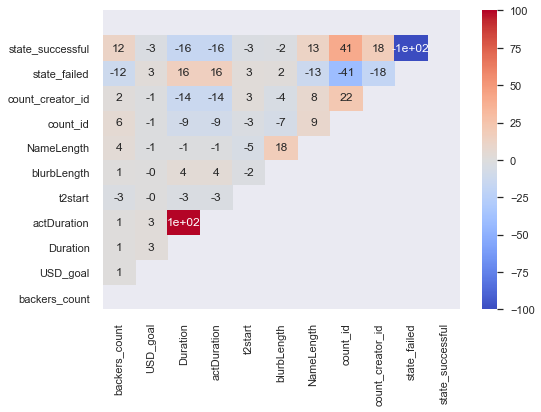

In [60]:
continuous_var = list(train_data.select_dtypes(
                        ['int64','float64']).columns.values)
continuous_var.append('state')
X_dum=pd.get_dummies(df2[continuous_var].copy())
mask = np.triu(X_dum.corr())
ax = sns.heatmap(round(X_dum.corr()*100.0)
                ,annot=True
                ,mask=mask,
                cmap='coolwarm')
ax.set_ylim((0,12))
plt.savefig('figures/correlogram.png')

* there is a strong correlation between backers_count and usd_pledged
* find out how to increase backers_count

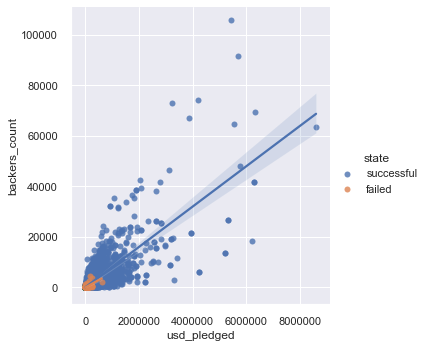

In [61]:
g = sns.lmplot(x='usd_pledged', y='backers_count', hue='state',data=df)
#sns.regplot(x="x", y="y", data=df, scatter=False, ax=g.axes[0, 0])
#sns.regplot(x=df.state,y = df.backers_count, scatter=False, ax=g.axes[0, 0]);

### Success

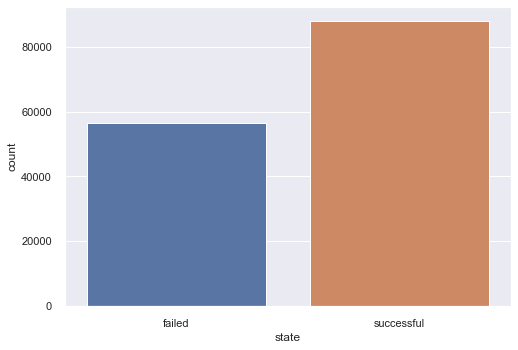

In [62]:
ax = sns.countplot(x="state", data=train_data)

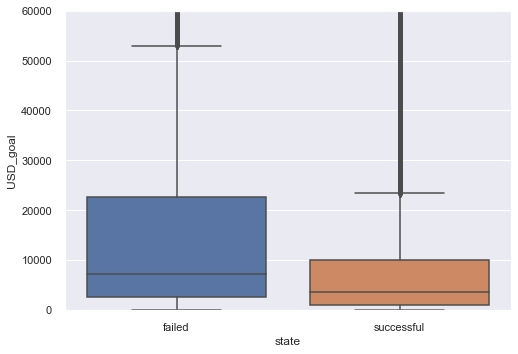

In [63]:
ax= sns.boxplot(x="state", y= "USD_goal", data=train_data)
ax.set(ylim=(0, 60000));

In [64]:
train_data.groupby("state")["USD_goal"].median()

state
failed        7213.27935
successful    3500.00000
Name: USD_goal, dtype: float64

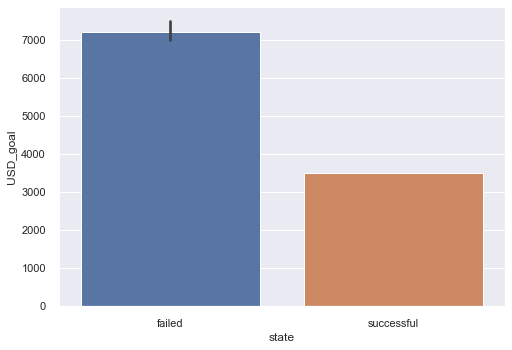

In [65]:
ax = sns.barplot(x="state", y="USD_goal", data=train_data, estimator=median)


### Country

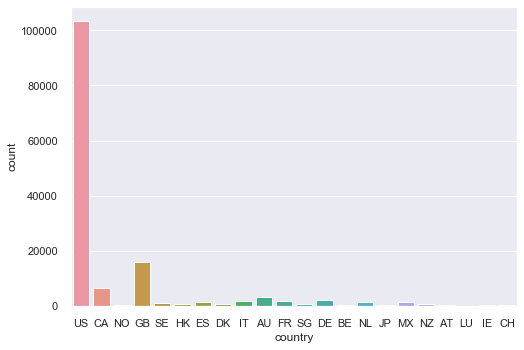

In [66]:
ax = sns.countplot(x="country", data=train_data)


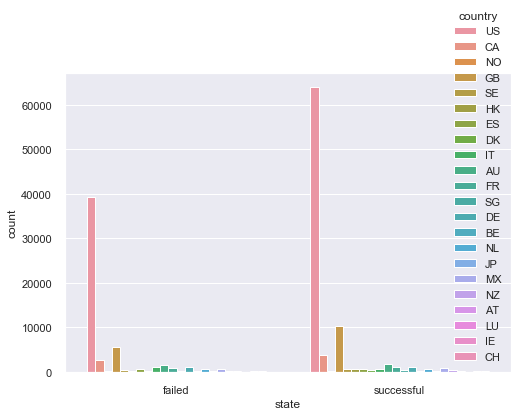

In [67]:
sns.countplot(x="state", data=train_data, hue="country")

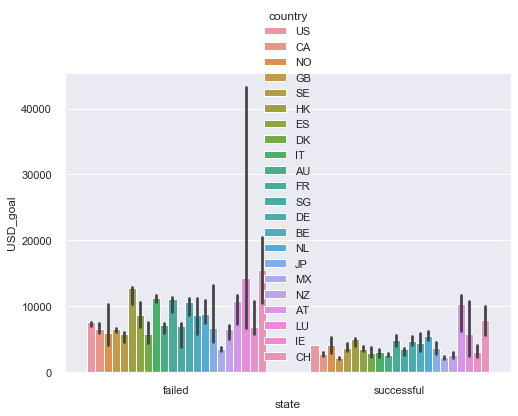

In [68]:
ax= sns.barplot(x="state", y= "USD_goal", data= train_data, estimator= median, hue="country")


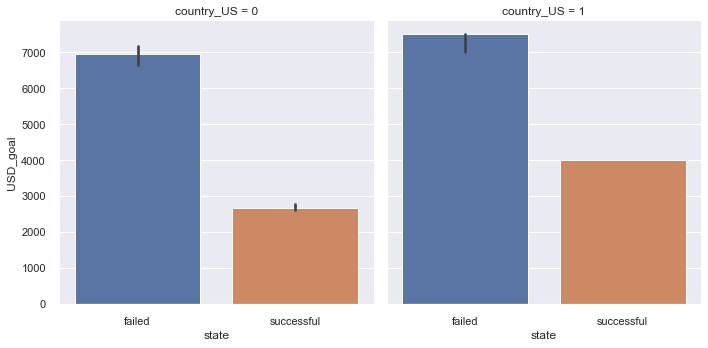

In [69]:
sns.catplot(x="state", y="USD_goal",
                col="country_US", estimator= median,
                kind="bar",
                data=train_data);

### ID

In [70]:
train_data["count_id"].value_counts()

1    109015
2     35483
Name: count_id, dtype: int64

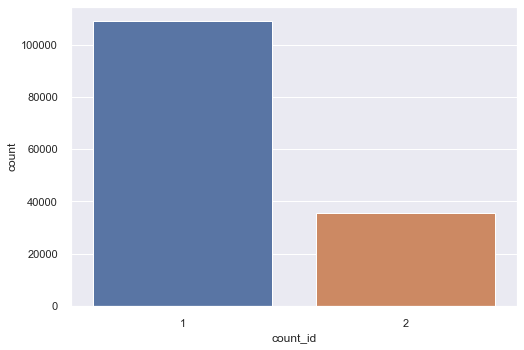

In [71]:
ax = sns.countplot(x="count_id", data=train_data)

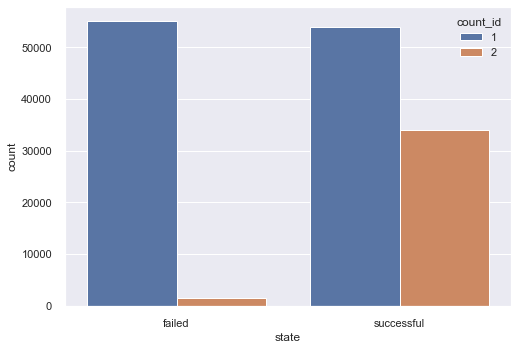

In [72]:
sns.countplot(x="state", data=train_data, hue="count_id")

### Category

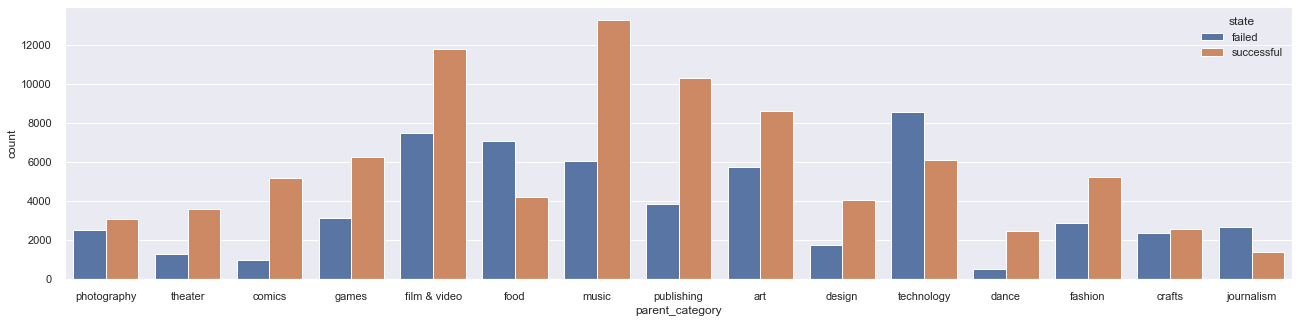

In [73]:
plt.figure(figsize=(22,5))
ax = sns.countplot(x="parent_category", hue= "state", data=train_data)

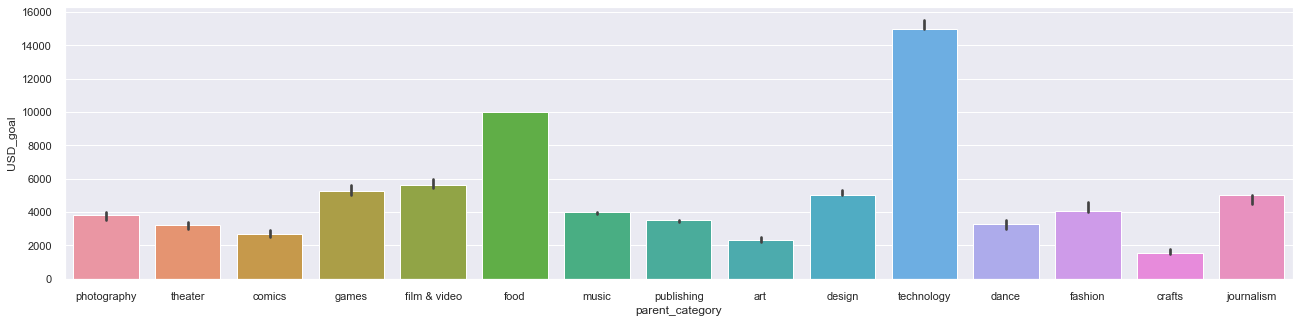

In [74]:
plt.figure(figsize=(22,5))
ax= sns.barplot(x="parent_category", y= "USD_goal", data= train_data, estimator= median)

# Predictive Modelling

## Built a pipeline

In [75]:
# Pipline for numerical features
num_pipeline = Pipeline([
    ('imputer_num',SimpleImputer(strategy='median')),
     ('std_scaler', StandardScaler())])
    
# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))])

In [76]:
# Complete pipeline
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)])

## Logistic regression

In [77]:
cat_features

['country',
 'currency',
 'usd_type',
 'category_name',
 'location_country',
 'location_type',
 'parent_category']

In [78]:
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])
# Making predictions on the training set using cross validation as well as calculating the probabilities 
y_train_predicted = cross_val_predict(pipe_logreg, X_train, y_train, cv=5)

In [79]:
# Calculating the accuracy for the LogisticRegression Classifier 
print('Cross validation scores:')
print('-------------------------')
print(classification_report(y_train, y_train_predicted))

Cross validation scores:
-------------------------
              precision    recall  f1-score   support

      failed       0.88      0.95      0.91     56545
  successful       0.96      0.92      0.94     87953

    accuracy                           0.93    144498
   macro avg       0.92      0.93      0.93    144498
weighted avg       0.93      0.93      0.93    144498



## Random Forrest

In [80]:
pipe_R_forest= Pipeline([('preprocessor', preprocessor),
                         ('R_Forrest_classifier', RandomForestClassifier(n_estimators=70))])

In [81]:
# Making predictions on the training set using cross validation as well as calculating the probabilities 
y_train_predicted = cross_val_predict(pipe_R_forest, X_train, y_train, cv=5)

In [82]:
# Calculating the accuracy for the LogisticRegression Classifier 
print('Cross validation scores:')
print('-------------------------')
print(classification_report(y_train, y_train_predicted))

Cross validation scores:
-------------------------
              precision    recall  f1-score   support

      failed       0.96      0.93      0.94     56545
  successful       0.96      0.97      0.96     87953

    accuracy                           0.96    144498
   macro avg       0.96      0.95      0.95    144498
weighted avg       0.96      0.96      0.96    144498



## Ada_boost

In [83]:
pipe_R_adaBoost= Pipeline([('preprocessor', preprocessor),
                         ('Ada_classifier', AdaBoostClassifier(random_state = RSEED,\
                                                           base_estimator=DecisionTreeClassifier()))])

In [84]:
# Making predictions on the training set using cross validation as well as calculating the probabilities 
y_train_predicted = cross_val_predict(pipe_R_adaBoost, X_train, y_train, cv=5)

In [85]:
# Calculating the accuracy for the AdaBoost Classifier 
print('Cross validation scores:')
print('-------------------------')
print(classification_report(y_train, y_train_predicted))

Cross validation scores:
-------------------------
              precision    recall  f1-score   support

      failed       0.93      0.93      0.93     56545
  successful       0.95      0.95      0.95     87953

    accuracy                           0.94    144498
   macro avg       0.94      0.94      0.94    144498
weighted avg       0.94      0.94      0.94    144498



## SVC

In [103]:
pipe_R_svc= Pipeline([('preprocessor', preprocessor),
                        ('svc_classifier', SVC(random_state = RSEED))])

In [ ]:
# Making predictions on the training set using cross validation as well as calculating the probabilities 
y_train_predicted = cross_val_predict(pipe_R_svc, X_train, y_train, cv=5,verbose=8)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.5min remaining:    0.0s


In [ ]:
# Calculating the accuracy for the LogisticRegression Classifier 
print('Cross validation scores:')
print('-------------------------')
print(classification_report(y_train, y_train_predicted))

## Grid Search

### Logistic Regression

In [88]:
params_logreg = {'logreg__penalty':('l1','l2'),
                'logreg__C': [0.01, 0.1, 1, 10, 100]
               } 

grid_logreg = GridSearchCV(pipe_logreg, param_grid=params_logreg, cv=3, scoring='accuracy', 
                           verbose=5, n_jobs=-1)


In [89]:
grid_logreg.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   48.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   48.2s finished
/Users/sandra/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer_num',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                

In [91]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_logreg.best_score_))
print("Best parameters:\n{}".format(grid_logreg.best_params_))

Best score:
0.95
Best parameters:
{'logreg__C': 100, 'logreg__penalty': 'l2'}


Best score:
0.95
Best parameters:
{'logreg__C': 100, 'logreg__penalty': 'l2'}

In [92]:
# Save best model as best_model
best_model_logReg = grid_logreg.best_estimator_['logreg']

### Random Forrest

In [93]:
samples_1 = int(round(len(X_train) / 100))
samples_10 = int(round(len(X_train) / 10))
samples_25 = int(round(len(X_train)/4))

params_RandomForrest = {'R_Forrest_classifier__bootstrap': [True, False],                
              'R_Forrest_classifier__max_depth': [1, 2, 4],               
              'R_Forrest_classifier__n_estimators': [samples_1, samples_10, samples_25],                             
             } 

grid_RandomForrest = GridSearchCV(pipe_R_forest, param_grid=params_RandomForrest, cv=3, scoring='accuracy', 
                           verbose=8, n_jobs=-1)
#{'bootstrap': [True, False],
# 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
# 'max_features': ['auto', 'sqrt'],
# 'min_samples_leaf': [1, 2, 4],
# 'min_samples_split': [2, 5, 10],
# 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [94]:
grid_RandomForrest.fit(X_train, y_train)
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_RandomForrest.best_score_))
print("Best parameters:\n{}".format(grid_RandomForrest.best_params_))

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 155.2min finished


Best score:
0.87
Best parameters:
{'R_Forrest_classifier__bootstrap': False, 'R_Forrest_classifier__max_depth': 4, 'R_Forrest_classifier__n_estimators': 1445}


Best score:  
0.87  
Best parameters:  
{'R_Forrest_classifier__bootstrap': False, 'R_Forrest_classifier__max_depth': 4, 'R_Forrest_classifier__n_estimators': 1445}

In [95]:
# Save best model as best_model
best_model_RandomForrest = grid_RandomForrest.best_estimator_['R_Forrest_classifier']

### AdaBoostClassifier

In [96]:
# TODO: Initialize the classifier
#clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier()) 

# TODO: Create the parameters list you wish to tune
params_Ada = {'Ada_classifier__n_estimators':[50, 120],                
              'Ada_classifier__learning_rate':[0.1, 0.5, 1.],               
              'Ada_classifier__base_estimator__min_samples_split' : np.arange(2, 8, 2),               
              'Ada_classifier__base_estimator__max_depth' : np.arange(1, 4, 1)              
             } 

grid_AdaBoost = GridSearchCV(pipe_R_adaBoost, param_grid=params_Ada, cv=3, scoring='accuracy', 
                           verbose=8, n_jobs=-1)


In [97]:
grid_AdaBoost.fit(X_train, y_train)
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_AdaBoost.best_score_))
print("Best parameters:\n{}".format(grid_AdaBoost.best_params_))

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 34.6min finished


Best score:
0.96
Best parameters:
{'Ada_classifier__base_estimator__max_depth': 2, 'Ada_classifier__base_estimator__min_samples_split': 2, 'Ada_classifier__learning_rate': 0.5, 'Ada_classifier__n_estimators': 120}


Best score:  
0.96  
Best parameters:  
{'Ada_classifier__base_estimator__max_depth': 2, 'Ada_classifier__base_estimator__min_samples_split': 2, 'Ada_classifier__learning_rate': 0.5, 'Ada_classifier__n_estimators': 120}

In [98]:
# Save best model as best_model
best_model_AdaBoost = grid_AdaBoost.best_estimator_['Ada_classifier']
#grid_AdaBoost.best_estimator_

### SVC

In [ ]:
# TODO: Initialize the classifier
#clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier()) 

# TODO: Create the parameters list you wish to tune
params_svc = {'svc_classifier__C':[1, 50, 120,1000],                
              'svc_classifier__gamma':[0.0005, 0.001, 0.005],               
              'svc_classifier__kernel' : ['linear','rbf']             
             } 

grid_SVC = GridSearchCV(pipe_R_svc, param_grid=params_svc, cv=3, scoring='accuracy', 
                           verbose=8, n_jobs=-1)

In [ ]:
grid_SVC.fit(X_train, y_train)
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_SVC.best_score_))
print("Best parameters:\n{}".format(grid_SVC.best_params_))

In [ ]:
# Save best model as best_model
best_model_SVC = grid_SVC.best_estimator_['svc_classifier']

## Final Evaluation

In [ ]:
# Preparing the test set 
preprocessor.fit(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [ ]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_test_predicted_logReg = best_model_logReg.predict(X_test_preprocessed)
y_test_predicted_RandomForrest = best_model_RandomForrest.predict(X_test_preprocessed)
y_test_predicted_AdaBoost = best_model_AdaBoost.predict(X_test_preprocessed)
y_test_predicted_svc = best_model_SVC.predict(X_test_preprocessed)
print(classification_report(y_train, y_test_predicted_logReg))
print()
print(classification_report(y_train, y_test_predicted_RandomForrest))
print()
print(classification_report(y_train, y_test_predicted_AdaBoost))
print()
print(classification_report(y_train, y_test_predicted_svc))
print()
#print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
#print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted)))
#print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted)))

In [ ]:
importances = best_model_logReg.feature_importances_
import matplotlib.patches as mpatches
import visuals as vs
# Plot
vs.feature_plot(importances, X_train, y_train)

In [ ]:
importances = best_model_AdaBoost.feature_importances_
# Plot
vs.feature_plot(importances, X_train, y_train)

In [102]:
#for i,model in enumerate([best_model_logReg,best_model_RandomForrest,best_model_AdaBoost,best_model_SVC]):
for i,model in enumerate([best_model_logReg,best_model_RandomForrest,best_model_AdaBoost]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

    # view with a heatmap
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

ValueError: could not convert string to float: 'US'

In [ ]:
#votingClassifier = VotingClassifier(estimators=[
#        ('p1', pipe1), ('p2', pipe2)])

In [ ]:
#model = AdaBoostClassifier().fit(X_train,y_train)

# TODO: Extract the feature importances
#importances = model.feature_importances_

# Plot
#vs.feature_plot(importances, X_train, y_train)


In [ ]:
# Import functionality for cloning a model


# Reduce the feature space
#X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
#X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
#clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
#reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
#print("Final Model trained on full data\n------")
#print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
#print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
#print("\nFinal Model trained on reduced data\n------")
#print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
#print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

# Data Visualization

# Summary

# Future Work 